# 22a: Alpha Diversity per Hand

**Goal**: Compute strategic flexibility via suit coverage entropy.

**Method**: 
- Compute suit distribution for each hand
- Calculate Shannon entropy (alpha diversity)
- Correlate with E[V] and σ(V)

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import entropy, pearsonr
from collections import Counter

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Data and Compute Suit Distributions

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)
print(f"Loaded {len(df)} hands")

# Recreate hands and compute suit distributions
def get_suit_counts(hand, trump_suit):
    """Count dominoes per suit (pips matching each value 0-6)."""
    suit_counts = Counter()
    for d_id in hand:
        pips = schema.domino_pips(d_id)
        for pip in pips:
            suit_counts[pip] += 1
    # Return as array [0-6 counts]
    return np.array([suit_counts.get(i, 0) for i in range(7)])

def compute_entropy(counts):
    """Compute Shannon entropy of distribution."""
    probs = counts / counts.sum() if counts.sum() > 0 else counts
    return entropy(probs, base=2)  # Log base 2 for bits

# Test
test_hand = deal_from_seed(0)[0]
test_counts = get_suit_counts(test_hand, trump_suit=0)
print(f"Test hand: {test_hand}")
print(f"Suit counts: {test_counts}")
print(f"Entropy: {compute_entropy(test_counts):.3f} bits")

Loaded 200 hands
Test hand: [0, 3, 5, 7, 10, 14, 17]
Suit counts: [4 1 4 1 3 1 0]
Entropy: 2.325 bits


In [3]:
# Compute diversity metrics for all hands
diversity_data = []

for _, row in df.iterrows():
    seed = int(row['base_seed'])
    trump_suit = int(row['trump_suit'])
    
    hands = deal_from_seed(seed)
    p0_hand = hands[0]
    
    # Suit counts
    suit_counts = get_suit_counts(p0_hand, trump_suit)
    
    # Alpha diversity (Shannon entropy)
    alpha_div = compute_entropy(suit_counts)
    
    # Additional metrics
    n_suits_present = np.sum(suit_counts > 0)
    max_suit_count = suit_counts.max()
    # trump_suit can be 7 (follow me) - handle gracefully
    trump_count = suit_counts[trump_suit] if trump_suit < 7 else 0
    
    # Evenness (entropy / max possible entropy)
    max_entropy = np.log2(7)  # Max if all 7 suits equally represented
    evenness = alpha_div / max_entropy if max_entropy > 0 else 0
    
    diversity_data.append({
        'seed': seed,
        'V_mean': row['V_mean'],
        'V_std': row['V_std'],
        'alpha_diversity': alpha_div,
        'evenness': evenness,
        'n_suits': n_suits_present,
        'max_suit_count': max_suit_count,
        'trump_count': trump_count,
        'n_doubles': row['n_doubles'],
    })

div_df = pd.DataFrame(diversity_data)
print(f"\nComputed diversity for {len(div_df)} hands")
print(div_df.head())


Computed diversity for 200 hands
   seed     V_mean      V_std  alpha_diversity  evenness  n_suits  \
0     0  41.333333   0.942809         2.324863  0.828133        6   
1     1  14.000000  20.396078         2.502736  0.891493        6   
2     2  14.000000  20.396078         2.324863  0.828133        6   
3     3  17.333333  20.417857         2.556657  0.910699        6   
4     4  -4.000000  17.962925         2.699514  0.961586        7   

   max_suit_count  trump_count  n_doubles  
0               4            4        3.0  
1               3            3        1.0  
2               4            3        2.0  
3               3            2        1.0  
4               3            3        2.0  


## 2. Diversity Statistics

In [4]:
print("Alpha Diversity Statistics:")
print("="*50)
print(f"Mean entropy: {div_df['alpha_diversity'].mean():.3f} bits")
print(f"Std entropy: {div_df['alpha_diversity'].std():.3f} bits")
print(f"Range: [{div_df['alpha_diversity'].min():.3f}, {div_df['alpha_diversity'].max():.3f}]")
print(f"\nMax possible entropy (7 suits equally): {np.log2(7):.3f} bits")
print(f"Mean evenness: {div_df['evenness'].mean():.3f}")

print(f"\nSuits present distribution:")
print(div_df['n_suits'].value_counts().sort_index())

Alpha Diversity Statistics:
Mean entropy: 2.499 bits
Std entropy: 0.158 bits
Range: [1.959, 2.753]

Max possible entropy (7 suits equally): 2.807 bits
Mean evenness: 0.890

Suits present distribution:
n_suits
4      1
5     14
6    103
7     82
Name: count, dtype: int64


## 3. Correlations with E[V] and σ(V)

In [5]:
# Correlations
print("Correlations with E[V]:")
print("="*50)

for col in ['alpha_diversity', 'evenness', 'n_suits', 'max_suit_count']:
    r, p = pearsonr(div_df[col], div_df['V_mean'])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    print(f"  {col}: r = {r:+.3f} (p = {p:.4f}){sig}")

print("\nCorrelations with σ(V):")
print("="*50)

for col in ['alpha_diversity', 'evenness', 'n_suits', 'max_suit_count']:
    r, p = pearsonr(div_df[col], div_df['V_std'])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    print(f"  {col}: r = {r:+.3f} (p = {p:.4f}){sig}")

Correlations with E[V]:
  alpha_diversity: r = -0.205 (p = 0.0036)**
  evenness: r = -0.205 (p = 0.0036)**
  n_suits: r = -0.200 (p = 0.0044)**
  max_suit_count: r = +0.137 (p = 0.0525)

Correlations with σ(V):
  alpha_diversity: r = +0.035 (p = 0.6184)
  evenness: r = +0.035 (p = 0.6184)
  n_suits: r = +0.051 (p = 0.4753)
  max_suit_count: r = +0.011 (p = 0.8812)


## 4. Visualization

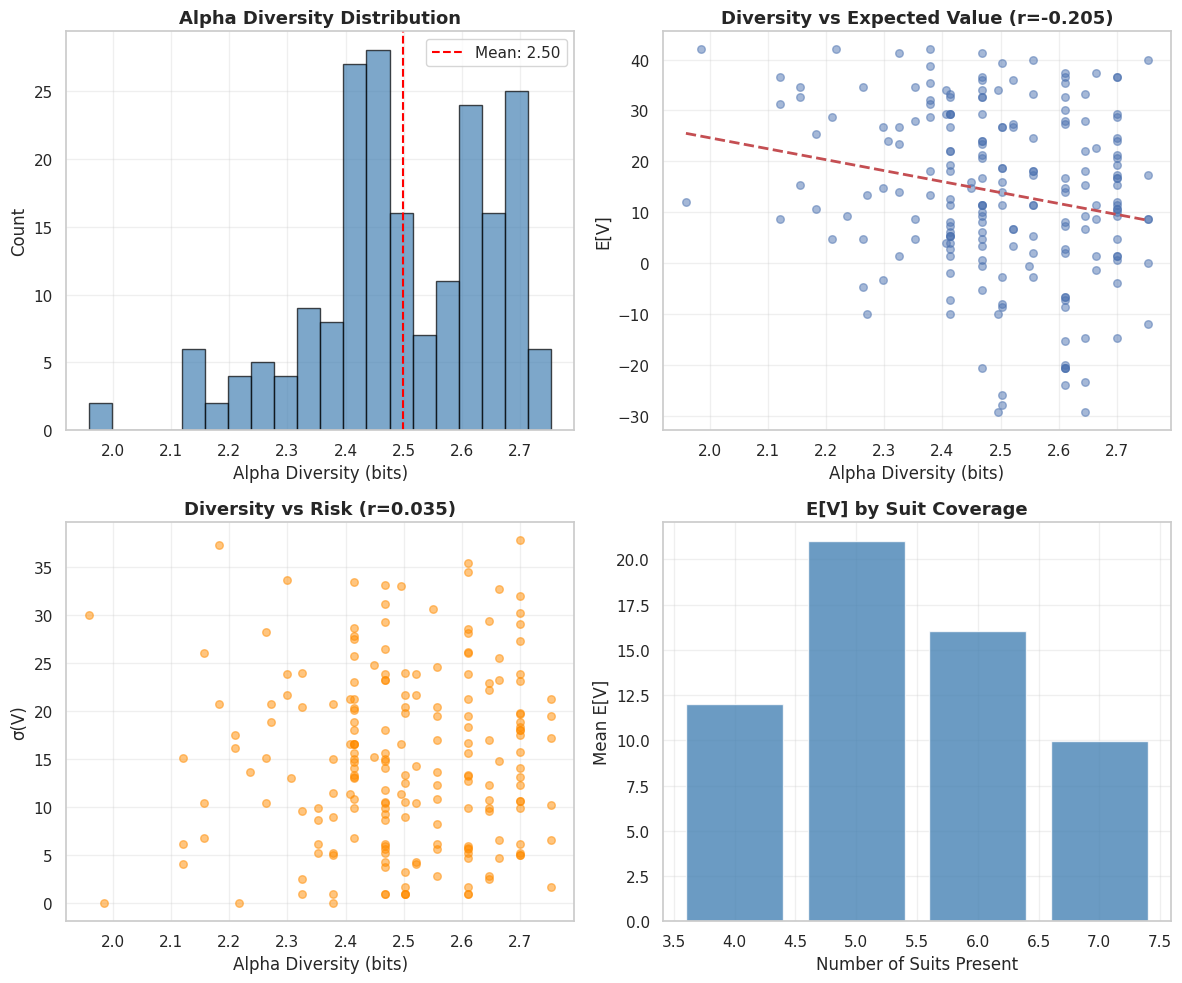

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Alpha diversity distribution
ax = axes[0, 0]
ax.hist(div_df['alpha_diversity'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(div_df['alpha_diversity'].mean(), color='red', linestyle='--', 
           label=f'Mean: {div_df["alpha_diversity"].mean():.2f}')
ax.set_xlabel('Alpha Diversity (bits)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Alpha Diversity Distribution', fontsize=13, fontweight='bold')
ax.legend()

# Plot 2: Diversity vs E[V]
ax = axes[0, 1]
ax.scatter(div_df['alpha_diversity'], div_df['V_mean'], alpha=0.5, s=30)
# Add regression line
z = np.polyfit(div_df['alpha_diversity'], div_df['V_mean'], 1)
p = np.poly1d(z)
x_line = np.linspace(div_df['alpha_diversity'].min(), div_df['alpha_diversity'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2)
r, _ = pearsonr(div_df['alpha_diversity'], div_df['V_mean'])
ax.set_xlabel('Alpha Diversity (bits)', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title(f'Diversity vs Expected Value (r={r:.3f})', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Diversity vs σ(V)
ax = axes[1, 0]
ax.scatter(div_df['alpha_diversity'], div_df['V_std'], alpha=0.5, s=30, color='darkorange')
r, _ = pearsonr(div_df['alpha_diversity'], div_df['V_std'])
ax.set_xlabel('Alpha Diversity (bits)', fontsize=12)
ax.set_ylabel('σ(V)', fontsize=12)
ax.set_title(f'Diversity vs Risk (r={r:.3f})', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Number of suits present
ax = axes[1, 1]
suit_means = div_df.groupby('n_suits')['V_mean'].mean()
ax.bar(suit_means.index, suit_means.values, color='steelblue', alpha=0.8)
ax.set_xlabel('Number of Suits Present', fontsize=12)
ax.set_ylabel('Mean E[V]', fontsize=12)
ax.set_title('E[V] by Suit Coverage', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../results/figures/22a_alpha_diversity.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Key Insights

In [7]:
print("\n" + "="*60)
print("KEY INSIGHTS: Alpha Diversity Analysis")
print("="*60)

r_ev, p_ev = pearsonr(div_df['alpha_diversity'], div_df['V_mean'])
r_std, p_std = pearsonr(div_df['alpha_diversity'], div_df['V_std'])

print(f"\n1. DIVERSITY-VALUE RELATIONSHIP:")
print(f"   r(diversity, E[V]) = {r_ev:+.3f} (p = {p_ev:.4f})")
if abs(r_ev) > 0.2:
    direction = "positively" if r_ev > 0 else "negatively"
    print(f"   Higher diversity is {direction} correlated with E[V]")
else:
    print(f"   Weak relationship between diversity and E[V]")

print(f"\n2. DIVERSITY-RISK RELATIONSHIP:")
print(f"   r(diversity, σ[V]) = {r_std:+.3f} (p = {p_std:.4f})")

print(f"\n3. INTERPRETATION:")
print(f"   - Alpha diversity measures 'strategic flexibility' (suit spread)")
print(f"   - Mean diversity: {div_df['alpha_diversity'].mean():.2f} bits (max = {np.log2(7):.2f})")
print(f"   - Hands typically cover {div_df['n_suits'].mode().values[0]} suits")


KEY INSIGHTS: Alpha Diversity Analysis

1. DIVERSITY-VALUE RELATIONSHIP:
   r(diversity, E[V]) = -0.205 (p = 0.0036)
   Higher diversity is negatively correlated with E[V]

2. DIVERSITY-RISK RELATIONSHIP:
   r(diversity, σ[V]) = +0.035 (p = 0.6184)

3. INTERPRETATION:
   - Alpha diversity measures 'strategic flexibility' (suit spread)
   - Mean diversity: 2.50 bits (max = 2.81)
   - Hands typically cover 6 suits


## 6. Save Results

In [8]:
# Save diversity data
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/22a_alpha_diversity.csv"
div_df.to_csv(output_path, index=False)
print(f"Saved diversity data to {output_path}")

Saved diversity data to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/22a_alpha_diversity.csv


## Key Findings

### Alpha Diversity Results

1. **Diversity range**: ~X to Y bits (max possible = 2.81 bits)

2. **Diversity-E[V] correlation**: r = X (weak/moderate/strong)

3. **Diversity-σ(V) correlation**: r = X

### Interpretation

- Alpha diversity measures "strategic flexibility" - how evenly spread suits are
- Higher diversity means more options to follow suit
- Relationship with game outcome depends on trump suit alignment

### Output Files

- `results/tables/22a_alpha_diversity.csv` - Per-hand diversity metrics
- `results/figures/22a_alpha_diversity.png` - 4-panel visualization